# XGBOOST Implementation

In [1]:
# Load Python libraries
from sklearn import metrics, ensemble
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# Load data
df = pd.read_csv('input/training/source_data/train.csv')

# 1% sample of items
df = df.sample(frac=0.01)

In [3]:
# Load and join songs data
songs = pd.read_csv('input/training/source_data/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('input/training/source_data/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 18 columns):
msno                      15000 non-null object
song_id                   15000 non-null object
source_system_tab         14964 non-null object
source_screen_name        14348 non-null object
source_type               14970 non-null object
target                    15000 non-null int64
song_length               15000 non-null int64
genre_ids                 14766 non-null object
artist_name               15000 non-null object
composer                  11745 non-null object
lyricist                  8788 non-null object
language                  15000 non-null float64
city                      15000 non-null int64
bd                        15000 non-null int64
gender                    9175 non-null object
registered_via            15000 non-null int64
registration_init_time    15000 non-null int64
expiration_date           15000 non-null int64
dtypes: float64(1), int64(7), objec

In [5]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.240000
source_screen_name         4.346667
source_type                0.200000
target                     0.000000
song_length                0.000000
genre_ids                  1.560000
artist_name                0.000000
composer                  21.700000
lyricist                  41.413333
language                   0.000000
city                       0.000000
bd                         0.000000
gender                    38.833333
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [6]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,5PbBykvNqwYVVepugrfvkMFjAJjciS8TAuv4qX9/r2o=,aRZlTjtdmMG2jifvMN/mBcl+SWyXB+zxbrZjoO5LdFE=,my library,Local playlist more,local-library,1,229172,465,謝和弦 (R-chord),R-chord,...,female,3,2014-12-12,2017-09-12,2014,12,12,2017,9,12
1,lnoxvmKGSqEhA/FDN9JxNUoz6sUlyMCu7AAJNMUE5ac=,Jw0CAzRAZCaiRzBJAjoGGqY+cVxBX4z+V/oeJ7muYfU=,my library,Local playlist more,local-library,1,315373,465,藍又時 (Shadya Lan),藍又時,...,female,3,2013-09-12,2017-10-01,2013,9,12,2017,10,1
2,K7obY5lUlZTd6a/byE9NG/e7Q/dlgHfppLbYk8OL7os=,IdOjsvQSPcRRnjLTHjog6bPk2tD0t2mbIrRvgiIZE0A=,my library,Local playlist more,local-library,1,294164,465,林俊傑 (JJ Lin),JJ Lin,...,male,3,2014-03-17,2018-01-13,2014,3,17,2018,1,13
3,a7CcAGHxrSitv6Sxs+R2x2MtlKDn69x7zZesc+uGrcc=,oap6kpthib/IaDsMi1BBWWaTBJv4iyC8kIwLq5kZRks=,my library,Local playlist more,album,0,241449,465,Ed Sheeran,unknown,...,female,9,2012-12-25,2018-01-03,2012,12,25,2018,1,3
4,OfqZlbit7E0SHwkHA3nb9WbFYM3eFHtJiWqY+lgW7UQ=,DvHKv+E/ddqTfv7qcaWi9a9pQ1V/iViKK48l8y9+sjo=,discover,Online playlist more,online-playlist,1,261590,465,飛兒樂團 (F.I.R.),F.I.R.,...,male,7,2010-10-30,2017-09-16,2010,10,30,2017,9,16


In [9]:
# Dates to category
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [10]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

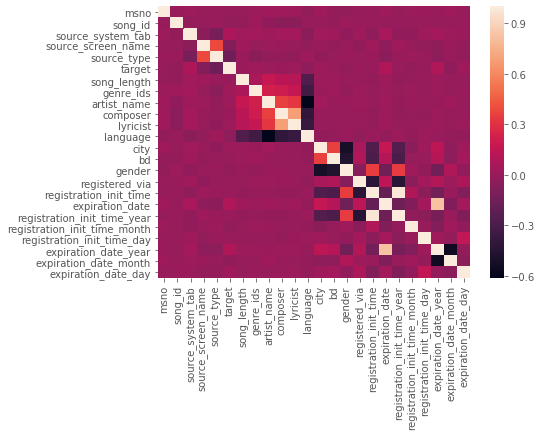

In [11]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
fig1 = sns.heatmap(df.corr())
plt.show()
#fig1 = plt.gcf()
#fig1.savefig('CoRelationMatrix.png')
fig = fig1.get_figure()
fig.savefig('XGBoostPlots/CoRelationMatrix.png', bbox_inches='tight')

In [12]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist'], 1)

In [13]:
# Model with the best estimator
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

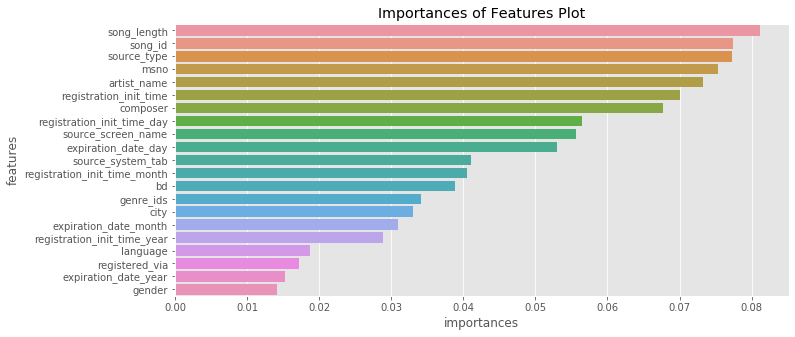

In [15]:
plt.figure(figsize=[11,5])
fig1 = sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()
#fig1 = plt.gcf()
#fig1.savefig('FeatureImportance.png', dpi=100)
fig = fig1.get_figure()
fig.savefig('XGBoostPlots/FeatureImportance.png', bbox_inches='tight')

In [16]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [17]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'artist_name', 'composer',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

# XGBOOST

In [18]:
target = df.pop('target')
target

0        1
1        1
2        1
3        0
4        1
5        0
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       0
18       1
19       1
20       1
21       1
22       0
23       1
24       1
25       1
26       1
27       0
28       1
29       0
        ..
14970    1
14971    0
14972    1
14973    0
14974    0
14975    1
14976    1
14977    0
14978    1
14979    1
14980    1
14981    1
14982    1
14983    1
14984    1
14985    1
14986    1
14987    0
14988    1
14989    1
14990    1
14991    0
14992    0
14993    0
14994    0
14995    1
14996    1
14997    0
14998    1
14999    1
Name: target, Length: 15000, dtype: int64

In [19]:
# Train & Test split
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [23]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=300)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [24]:
# Predicting
predict_labels = model.predict(test_data)

In [25]:
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.61      0.40      0.48      1529
           1       0.74      0.87      0.80      2971

    accuracy                           0.71      4500
   macro avg       0.67      0.63      0.64      4500
weighted avg       0.69      0.71      0.69      4500

